#Parcial #4, Metodos Computacionales#
****
**Realizado por:** Juan Sebastian Pabon Martinez

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.optimize as spo

In [169]:
url = 'https://raw.githubusercontent.com/asegura4488/Database/main/MetodosComputacionalesReforma/DataRotacion.csv'
Data = pd.read_csv(url)

In [171]:

def filter(data,angle):
  return data[data.angle == 30.0]

data=filter(Data,30)
data

,h,angle,y,sigmay
20,10.0,30.0,0.0013,0.0015
21,20.0,30.0,0.0017,0.0015
22,30.0,30.0,0.0038,0.0015
23,40.0,30.0,0.0059,0.0015
24,50.0,30.0,0.0067,0.0015
25,60.0,30.0,0.0094,0.0015
26,70.0,30.0,0.0122,0.0015
27,80.0,30.0,0.0132,0.0015
28,90.0,30.0,0.0151,0.0015
29,100.0,30.0,0.0186,0.0015


In [58]:
def coriolis(h,lamda,p,g=9.81):
  one= np.sqrt(2)*2*(1/3)
  two=p*np.cos(np.deg2rad(lamda))
  three= np.sqrt(h**3/g)
  y=one*two*three
  return y

In [59]:
def Chi2(p,h,y,sigmay,angle=30,g=9.81):
    return np.sum ( (y-coriolis(h,angle,p))**2/(2*sigmay**2) )


In [60]:
h=data.h
y= data.y
sigma= data.sigmay

In [61]:
p=np.ones(1)
nll = lambda *p: Chi2(*p)

resultado = spo.minimize( nll, p, args=(h,y,sigma),options={'disp':True} )

Optimization terminated successfully.
         Current function value: 1.145718
         Iterations: 3
         Function evaluations: 8
         Gradient evaluations: 4


In [62]:
omega= resultado.x
print("El valor mejor aproximado para omega es: {}".format(omega))

El valor mejor aproximado para omega es: [7.24399804e-05]


Text(0, 0.5, 'y')

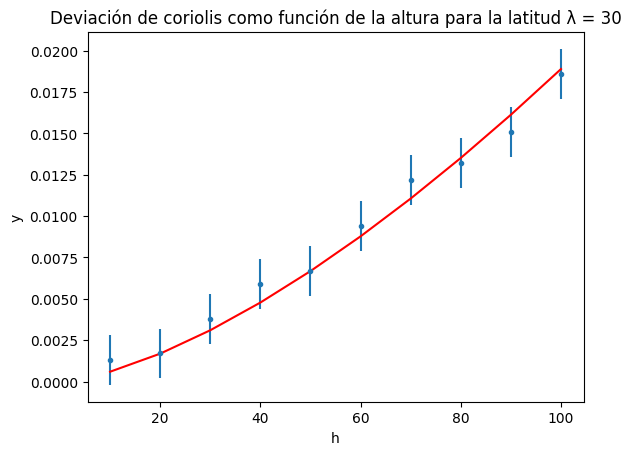

In [63]:
modelo= coriolis(h,30,omega)
plt.errorbar(h,y,sigma,fmt='.')
plt.plot(h,modelo,color='r')
plt.title('Deviación de coriolis como función de la altura para la latitud λ = 30')
plt.xlabel('h')
plt.ylabel('y')

#**Propagación de la incertidumbre de la aceleración de la gravedad:**

In [148]:
y = np.array(data.y)
h =  np.array(data.h)
sigmay = np.array(data.sigmay)

In [149]:

def Estimacion(y, h, sigmay, angle):
  Gravity= np.zeros(300)
  Omega=np.zeros(300)
  for i in range(300):
    G = 9.81 + np.random.normal(loc=0,scale=1)
    Gravity[i]= G
    y_modified = y + np.random.normal(loc=0,scale=sigmay[0],size=len(y))
    result_ = spo.minimize(nll,p, args=(h,y_modified,sigmay,G),options={'disp':True})
    Omega[i]= result_.x

  return Omega,Gravity


In [150]:
def Continue_Distribution (Omega,Gravity):
  gridy = np.linspace(min(Gravity),max(Gravity),30)
  gridx = np.linspace(min(Omega),max(Omega),30)
  H2, binsx, binsy = np.histogram2d(Omega,Gravity,bins=(gridx,gridy))
  return H2, binsx, binsy 


In [151]:
Omega_30,Gravity_30= Estimacion(y, h, sigmay, 30)
H2_30,binsx_30,binsy_30=Continue_Distribution(Omega_30,Gravity_30)

Optimization terminated successfully.
         Current function value: 7.488956
         Iterations: 3
         Function evaluations: 8
         Gradient evaluations: 4
Optimization terminated successfully.
         Current function value: 15.517084
         Iterations: 3
         Function evaluations: 8
         Gradient evaluations: 4
Optimization terminated successfully.
         Current function value: 3.716152
         Iterations: 3
         Function evaluations: 8
         Gradient evaluations: 4
Optimization terminated successfully.
         Current function value: 5.811566
         Iterations: 3
         Function evaluations: 8
         Gradient evaluations: 4
Optimization terminated successfully.
         Current function value: 4.409150
         Iterations: 3
         Function evaluations: 8
         Gradient evaluations: 4
         Current function value: 8.980233
         Iterations: 2
         Function evaluations: 112
         Gradient evaluations: 50
Optimization termina

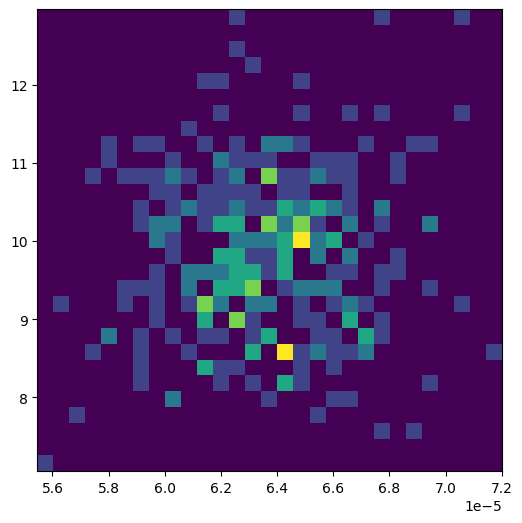

In [152]:
fig= plt.figure(figsize=(6,6))
plt.imshow(H2_30.T, origin='lower', extent=[binsx_30[0], binsx_30[-1], binsy_30[0], binsy_30[-1]], aspect='auto')

g) Son dependientes

In [154]:
#h
H1 = np.sum(H2_30,axis=1)
H1

array([ 1.,  1.,  1.,  2.,  4.,  3.,  9., 11., 12., 10., 18., 23., 28.,
       22., 22., 27., 23., 18., 15., 17.,  8., 10.,  4.,  2.,  5.,  0.,
        3.,  0.,  1.])

In [161]:
#i
def trust_interval (H2,binsx):
  H1 = np.sum(H2,axis=1)
  cs = np.cumsum(H1)
  ij = np.searchsorted( cs, np.percentile(cs,16) )
  ii = np.searchsorted( cs, np.percentile(cs,50) )
  ji = np.searchsorted( cs, np.percentile(cs,84) )
  best_omega= binsx[ii]
  upper_limit= binsx[ji]
  lower_limit= binsx[ij]
  return best_omega,lower_limit,upper_limit

best_omega,lower_limit,upper_limit= trust_interval(H2_30,binsx_30)

print("El mejor estimados para omega en lambda= 30 es: {}".format(best_omega))
print("El intervalo de confianza al 68% para lamda = 30 es {} y {}".format(lower_limit,upper_limit))

El mejor estimados para omega en lambda= 30 es: 6.345877643045136e-05
El intervalo de confianza al 68% para lamda = 30 es 5.831985300782861e-05 y 6.916869134447662e-05


In [167]:
angles=[10.0,20.0,30.0,40.0,50.0,60.0]
best_omegas=[]
lower_limits= []
upper_limits=[]
for i in range(len(angles)):
  n_data=filter(Data,angles[i])
  y = np.array(n_data.y)
  h =  np.array(n_data.h)
  sigmay = np.array(n_data.sigmay)
  Omega_n,Gravity_n= Estimacion(y, h, sigmay, 30)
  H2_n,binsx_n,binsy_n=Continue_Distribution(Omega_n,Gravity_n)
  best_omega,lower_limit,upper_limit= trust_interval(H2_n,binsx_n)
  best_omegas.append(best_omega)
  lower_limits.append(lower_limit)
  upper_limits.append(upper_limit)


Se han truncado las últimas 5000 líneas del flujo de salida.
         Current function value: 5.802273
         Iterations: 2
         Function evaluations: 74
         Gradient evaluations: 31
         Current function value: 7.541348
         Iterations: 2
         Function evaluations: 92
         Gradient evaluations: 40
Optimization terminated successfully.
         Current function value: 4.835252
         Iterations: 3
         Function evaluations: 8
         Gradient evaluations: 4
Optimization terminated successfully.
         Current function value: 8.586451
         Iterations: 3
         Function evaluations: 8
         Gradient evaluations: 4
         Current function value: 6.612054
         Iterations: 2
         Function evaluations: 84
         Gradient evaluations: 36
Optimization terminated successfully.
         Current function value: 6.672782
         Iterations: 3
         Function evaluations: 8
         Gradient evaluations: 4
         Current function value: 

[6.380603398426053e-05,
 6.383308464409414e-05,
 6.429766400817613e-05,
 6.364517031297964e-05,
 6.394711682940108e-05,
 6.22941566450668e-05]

In [168]:
best_omegas

[6.380603398426053e-05,
 6.383308464409414e-05,
 6.429766400817613e-05,
 6.364517031297964e-05,
 6.394711682940108e-05,
 6.22941566450668e-05]